# Mahesh Gaire - MSCS 634 - Lab 3: Wine Dataset Clustering
**Name:** Mahesh Gaire  
**Course:** MSCS 634 - Machine Learning  
**Lab:** Lab 3 - Clustering with K-Means and K-Medoids

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

from pyclustering.cluster.kmedoids import kmedoids

sns.set(style="whitegrid")


In [3]:
# Load Wine dataset
wine = load_wine(as_frame=True)
X = wine.data
y = wine.target
print("Feature shape:", X.shape)
print("Feature names:", list(X.columns))
print("Class distribution:")
print(y.value_counts())

Feature shape: (178, 13)
Feature names: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
Class distribution:
target
1    71
0    59
2    48
Name: count, dtype: int64


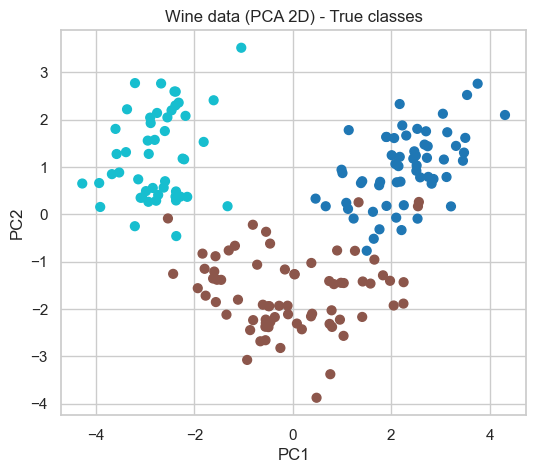

K-Means silhouette: 0.2849
K-Means ARI: 0.8975


In [4]:
# Standardize features (z-score)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled[:5]
# Reduce to 2D for visualization using PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='tab10', s=40)
plt.title('Wine data (PCA 2D) - True classes')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.show()

# Step 2: K-Means with k=3
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)
kmeans_sil = silhouette_score(X_scaled, kmeans_labels)
kmeans_ari = adjusted_rand_score(y, kmeans_labels)
print(f"K-Means silhouette: {kmeans_sil:.4f}")
print(f"K-Means ARI: {kmeans_ari:.4f}")

In [9]:
# Step 3: K-Medoids with k=3 using pyclustering (pure Python)
import random
# pyclustering's kmedoids expects list-of-lists data and initial medoid indices
data_list = X_scaled.tolist()
# choose initial medoids randomly (fixed seed for reproducibility)
random.seed(42)
initial_medoids = random.sample(range(len(data_list)), k)
kmedoids_instance = kmedoids(data_list, initial_medoids, data_type='points', ccore=False)
kmedoids_instance.process()
clusters = kmedoids_instance.get_clusters()
medoids = kmedoids_instance.get_medoids()
# convert clusters (lists of indices) to labels array
kmedoids_labels = np.empty(len(data_list), dtype=int)
for cluster_id, inds in enumerate(clusters):
    for idx in inds:
        kmedoids_labels[idx] = cluster_id
kmedoids_sil = silhouette_score(X_scaled, kmedoids_labels)
kmedoids_ari = adjusted_rand_score(y, kmedoids_labels)
print(f"K-Medoids silhouette: {kmedoids_sil:.4f}")
print(f"K-Medoids ARI: {kmedoids_ari:.4f}")

K-Medoids silhouette: 0.2676
K-Medoids ARI: 0.7411


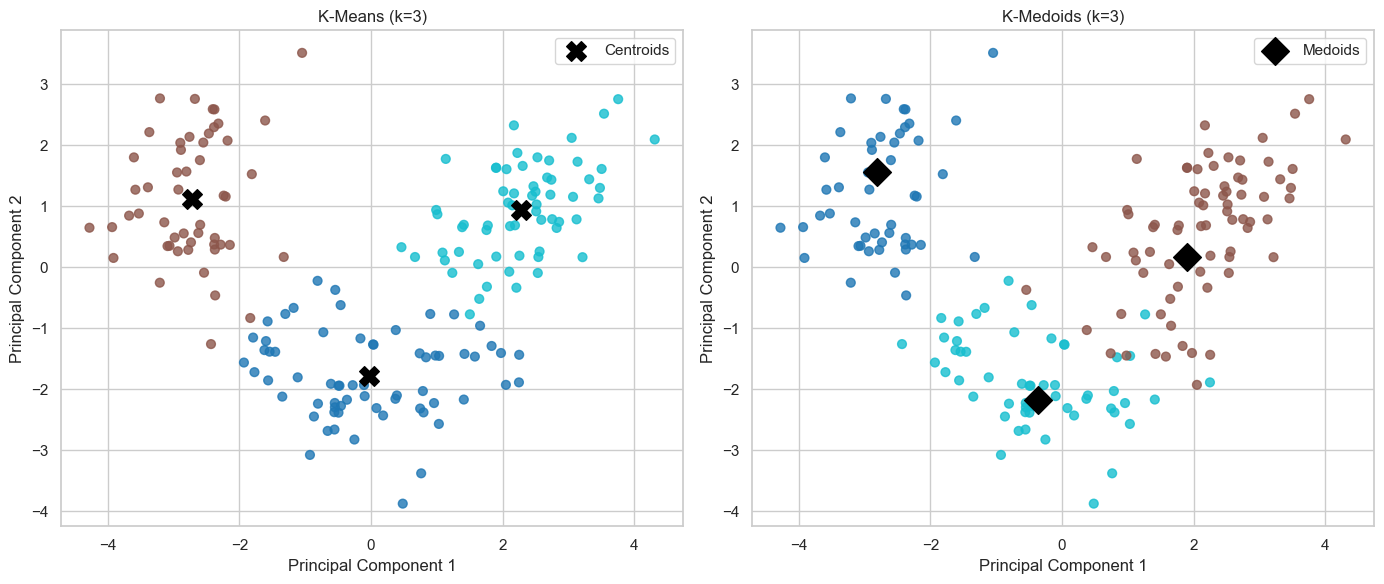

In [8]:
# Step 4: Visualization - Side-by-Side (K-Means vs K-Medoids using pyclustering)

fig, axes = plt.subplots(1, 2, figsize=(14,6))

# -----------------------------
# K-Means Plot
# -----------------------------
axes[0].scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=kmeans_labels,
    cmap='tab10',
    s=40,
    alpha=0.8
)

# Project KMeans centroids into PCA space
kmeans_centers_pca = pca.transform(kmeans.cluster_centers_)

axes[0].scatter(
    kmeans_centers_pca[:, 0],
    kmeans_centers_pca[:, 1],
    marker='X',
    c='black',
    s=200,
    label='Centroids'
)

axes[0].set_title('K-Means (k=3)', fontsize=12)
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')
axes[0].legend()
axes[0].grid(True)


# -----------------------------
# K-Medoids Plot (pyclustering)
# -----------------------------
axes[1].scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=kmedoids_labels,
    cmap='tab10',
    s=40,
    alpha=0.8
)

# IMPORTANT: use medoid indices returned from pyclustering
medoid_indices = kmedoids_instance.get_medoids()

medoids_pca = X_pca[medoid_indices]

axes[1].scatter(
    medoids_pca[:, 0],
    medoids_pca[:, 1],
    marker='D',
    c='black',
    s=200,
    label='Medoids'
)

axes[1].set_title('K-Medoids (k=3)', fontsize=12)
axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 2')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


## Brief Analysis and Observations
- **Which produced better-defined clusters?** Compare the Silhouette Score and ARI printed above. Higher silhouette indicates more well-separated clusters; higher ARI indicates closer match to true classes.
- **Differences observed:** K-Means uses means so centroids may lie between points and can be influenced by outliers; K-Medoids selects actual data points as centers (medoids), making it more robust to noise and outliers.
- **When to prefer which:** Use K-Means when clusters are roughly spherical and you expect low outlier influence and want speed. Use K-Medoids when robustness to outliers and arbitrary distance metrics are important.

**Notes:** The notebook standardizes features and visualizes clusters in PCA-reduced 2D for plotting clarity. For reproducible runs, a `random_state` is set on algorithms where applicable.